In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating environment at `c:\Users\amanc\Box\Spring_2023\16-745_OCRL\OCRL_proj\Project.toml`


In [2]:
# Packages
using CSV
using DataFrames
using Plots
using LinearAlgebra
import ForwardDiff
import Convex as cvx
import ECOS
import MathOptInterface as MOI
import Ipopt
using JLD2
using Random



In [27]:
include(joinpath(@__DIR__, "utils", "fmincon.jl"))

fmincon (generic function with 1 method)

## Data Processing

In [4]:
# Reading the dataset
path = @__DIR__
track_name = "Monza" # Put the track name
file_name = track_name * ".csv"
dataset_path = joinpath(path, "database", "tracks", file_name)
@show dataset_path

# Load the dataset
df = CSV.read(dataset_path, DataFrame);
# size of the dataset



dataset_path = "c:\\Users\\amanc\\Box\\Spring_2023\\16-745_OCRL\\OCRL_proj\\database\\tracks\\Monza.csv"


Row,# x_m,y_m,w_tr_right_m,w_tr_left_m
,Float64,Float64,Float64,Float64
1,-0.320123,1.08771,5.739,5.932
2,0.168262,6.06219,5.735,5.929
3,0.656139,11.0366,5.731,5.926
4,1.14355,16.0111,5.727,5.923
5,1.63054,20.9855,5.723,5.92
6,2.11714,25.9599,5.719,5.917
7,2.6034,30.9342,5.715,5.914
8,3.08936,35.9086,5.711,5.911
9,3.57507,40.8829,5.707,5.908


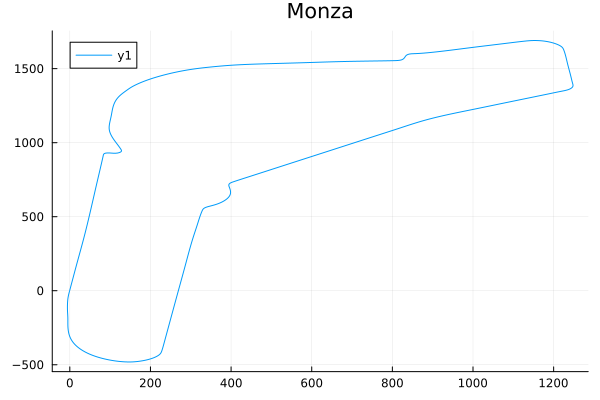

In [5]:
# separating the  columns
x = df[:, 1]
y = df[:, 2]
left_width = df[:, 3]
# @show left_width
right_width = df[:, 4];
# @show right_width
# Plotting the dataset
plot(x, y, legend=:topleft, title=track_name)

size(x_i) = (1159,)


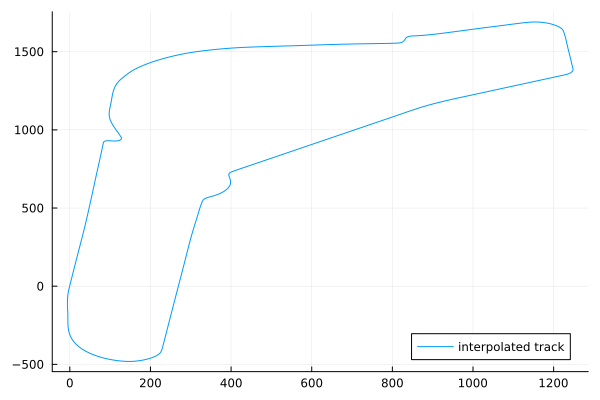

In [6]:
# interpolate data to get a smooth track
xy = [x y]
using Interpolations
itpx = interpolate(x, BSpline(Quadratic(Line())), OnGrid())
itpy = interpolate(y, BSpline(Quadratic(Line())), OnGrid())
itplw = interpolate(left_width, BSpline(Cubic()), OnGrid())
itprw = interpolate(right_width, BSpline(Cubic()), OnGrid())
x_i = itpx[1:1:length(itpx)]
y_i = itpy[1:1:length(itpy)]
left_width_i = itplw[1:1:length(itplw)]
right_width_i = itprw[1:1:length(itprw)];
@show size(x_i)
# plot x2 y2
plot(x_i, y_i, label="interpolated track", legend=:bottomright);

# to close loop repeat the first point

## Formulation of Geometric QP

offset = [-5.932 5.739; -5.929000000000001 5.735; -5.926 5.730999999999999; -5.923 5.727; -5.92 5.723; -5.917 5.719; -5.914 5.715; -5.911000000000001 5.711000000000001; -5.908 5.707; -5.905 5.703000000000001; -5.902000000000001 5.7; -5.899 5.696; -5.896 5.692000000000001; -5.893 5.688; -5.89 5.684; -5.887 5.68; -5.8839999999999995 5.676; -5.881000000000001 5.672000000000001; -5.878 5.668000000000001; -5.875 5.664; -5.872000000000001 5.66; -5.869 5.656000000000001; -5.865999999999999 5.652; -5.8629999999999995 5.648000000000001; -5.860000000000001 5.644; -5.858 5.640000000000001; -5.855 5.636000000000001; -5.852 5.632; -5.849000000000001 5.628; -5.846 5.624; -5.843 5.62; -5.84 5.616; -5.837 5.612; -5.834 5.608; -5.831000000000001 5.604; -5.828000000000001 5.6; -5.825 5.597000000000001; -5.822000000000001 5.593; -5.818999999999999 5.589; -5.816 5.585000000000001; -5.813 5.581; -5.81 5.577; -5.807 5.573000000000001; -5.804 5.569; -5.801000000000001 5.565000000000001; -5.798 5.561; -5.795 


size(offset) = (1159, 2)


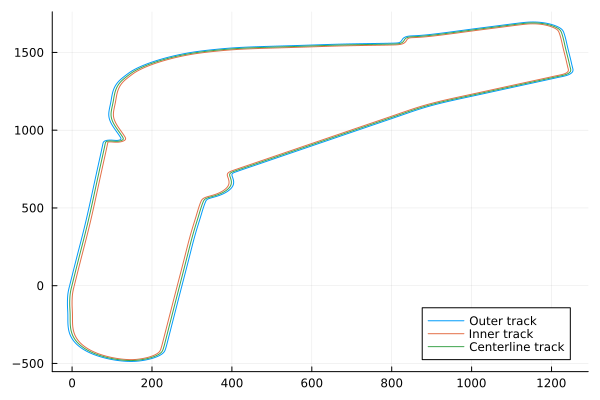

In [7]:
# get normals for x_i y_i left_width_i right_width_i points
# get the tangent vector
dx = diff(x_i)
dx = [dx; dx[1]]
dy = diff(y_i)
dy = [dy; dy[1]]
# @show length(dx)
# # calculate the hypothenuse using dx and dy
h = sqrt.(dx .^ 2 + dy .^ 2);

xout = zeros(length(x_i))
yout = zeros(length(y_i))
xin = zeros(length(x_i))
yin = zeros(length(y_i))

offset = [-right_width_i left_width_i]
@show offset
@show size(offset)

function xoff(a)
    return -a * dy ./ h + x_i
end
function yoff(a)
    return a * dx ./ h + y_i
end

for i in 1:length(x_i)
    xin = xoff(offset[i, 1])      # get inner offset curve
    yin = yoff(offset[i, 1])

    xout = xoff(offset[i, 2])    # get outer offset curve
    yout = yoff(offset[i, 2])
end

# plot the inner and outer track with the interpolated track
plot(xout, yout, label="Outer track", legend=:bottomright, linewidth=1)
plot!(xin, yin, label="Inner track", legend=:bottomright, linewidth=1)
plot!(x_i, y_i, label="Centerline track", legend=:bottomright, linewidth=1)

## Cost Function Calculation

In [8]:
delx = xout - xin
dely = yout - yin

n = length(delx)

H = zeros(n, n)
B = zeros(1, n)

# formation of H matrix
for i in 2:n-1
    # first row
    H[i-1, i-1] = H[i-1, i-1] + delx[i-1]^2 + dely[i-1]^2
    H[i-1, i] = H[i-1, i] - 2 * delx[i-1] * delx[i] - 2 * dely[i-1] * dely[i]
    H[i-1, i+1] = H[i-1, i+1] + delx[i-1] * delx[i+1] + dely[i-1] * dely[i+1]

    # second row
    H[i, i-1] = H[i, i-1] - 2 * delx[i-1] * delx[i] - 2 * dely[i-1] * dely[i]
    H[i, i] = H[i, i] + 4 * delx[i]^2 + 4 * dely[i]^2
    H[i, i+1] = H[i, i+1] - 2 * delx[i] * delx[i+1] - 2 * dely[i] * dely[i+1]

    # third row
    H[i+1, i-1] = H[i+1, i-1] + delx[i-1] * delx[i+1] + dely[i-1] * dely[i+1]
    H[i+1, i] = H[i+1, i] - 2 * delx[i] * delx[i+1] - 2 * dely[i] * dely[i+1]
    H[i+1, i+1] = H[i+1, i+1] + delx[i+1]^2 + dely[i+1]^2
end

# formation of B matrix (1xn)
for i in 2:n-1
    B[1, i-1] = B[1, i-1] + 2 * (xin[i+1] + xin[i-1] - 2 * xin[i]) * delx[i-1] + 2 * (yin[i+1] + yin[i-1] - 2 * yin[i]) * dely[i-1]
    B[1, i] = B[1, i] - 4 * (xin[i+1] + xin[i-1] - 2 * xin[i]) * delx[i] - 4 * (yin[i+1] + yin[i-1] - 2 * yin[i]) * dely[i]
    B[1, i+1] = B[1, i+1] + 2 * (xin[i+1] + xin[i-1] - 2 * xin[i]) * delx[i+1] + 2 * (yin[i+1] + yin[i-1] - 2 * yin[i]) * dely[i+1]
end


alpha = cvx.Variable(n)

# cost function
cost = 0.5 * cvx.quadform(alpha, H) + dot(B, alpha)
prob = cvx.minimize(cost)

Aeq = zeros(1,n)
Aeq[1] = 1
Aeq[end] = -1
beq = 0;
prob.constraints += alpha[1] == 0.5
prob.constraints += alpha <= ones(n)
prob.constraints += alpha >= zeros(n)

prob.constraints += (Aeq*alpha == beq)

cvx.solve!(prob, ECOS.Optimizer; silent_solver=false)

# xcvx = alpha.value::Matrix # This will always be a matrix
xcvx = vec(alpha.value) # convert to vector easily 

# plotting
xopt = zeros(size(x_i))
yopt = zeros(size(x_i))
for i = 1:length(x_i)
    xopt[i] = xin[i] + xcvx[i] * delx[i]
    yopt[i] = yin[i] + xcvx[i] * dely[i]
end



ECOS 2.0.8 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -3.446e+001  -1.230e+004  +2e+004  2e-001  1e-002  1e+000  1e+001    ---    ---    1  1  - |  -  - 
 1  -1.922e+002  -4.707e+003  +1e+004  6e-002  7e-003  2e+000  5e+000  0.6545  3e-001   1  1  1 |  0  0
 2  -2.073e+002  -6.577e+002  +2e+003  6e-003  2e-003  4e-001  7e-001  0.8851  2e-002   1  1  1 |  0  0
 3  -2.149e+002  -4.763e+002  +9e+002  3e-003  1e-003  2e-001  4e-001  0.4977  2e-001   2  2  2 |  0  0
 4  -2.127e+002  -4.813e+002  +9e+002  3e-003  6e-005  2e-001  4e-001  0.0154  1e+000   2  2  3 |  0  0
 5  -2.124e+002  -4.399e+002  +8e+002  3e-003  3e-005  2e-001  3e-001  0.3940  6e-001   3  3  2 |  0  0
 6  -2.112e+002  -4.373e+002  +7e+002  3e-003  2e-005  2e-001  3e-001  0.0761  7e-001   4  4  3 |  0  0
 7  -2.063e+002  -4.301e+002  +7e+002  3e-003  1e-005  1e-001  3e-001  0.3301  8e-001  

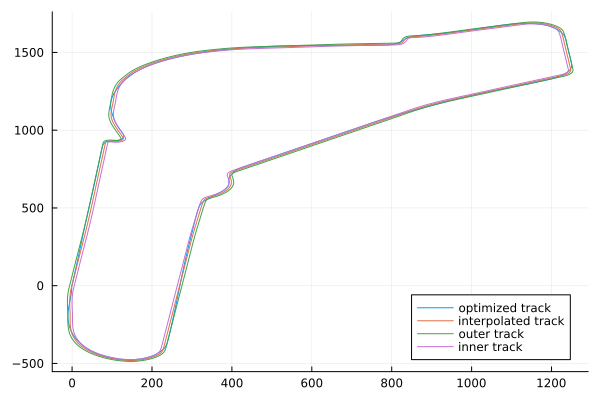

In [9]:
# Plotting the results
# plot xopt yopt
plot(xopt, yopt, label="optimized track", legend=:bottomright, linewidth=1)
# plot x_i y_i
plot!(x_i, y_i, label="interpolated track", legend=:bottomright, linewidth=1)
# plot xout yout
plot!(xout, yout, label="outer track", legend=:bottomright, linewidth=1)
# plot xin yin
plot!(xin, yin, label="inner track", legend=:bottomright, linewidth=1)

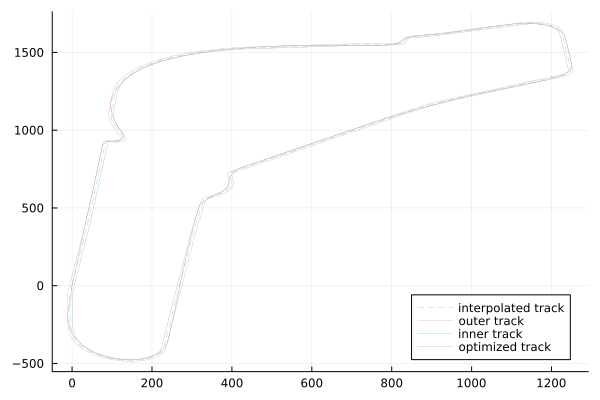

In [10]:
# plot x_i y_i
plot(x_i, y_i, label="interpolated track", legend=:bottomright, linewidth=0.2, linestyle=:dash)
# plot xout yout
plot!(xout, yout, label="outer track", legend=:bottomright, linewidth=0.2)
# plot xin yin
plot!(xin, yin, label="inner track", legend=:bottomright, linewidth=0.2)
# plot xopt yopt
plot!(xopt, yopt, label="optimized track", legend=:bottomright, linewidth=0.3)


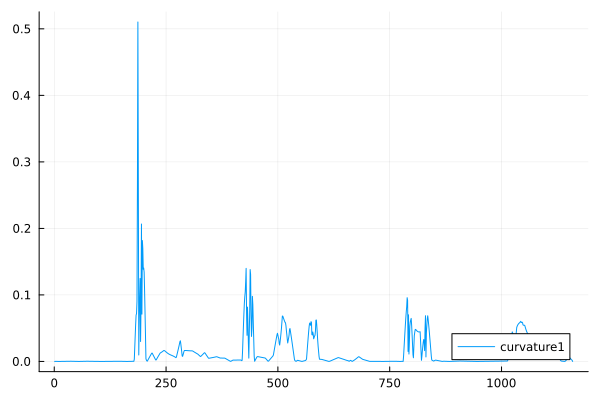

In [11]:
# take the second derivative of the optimized track
d2xopt = zeros(size(xopt))
d2yopt = zeros(size(xopt))
dxopt = zeros(size(xopt))
dyopt = zeros(size(xopt))
kappa1 = zeros(size(xopt))

for i in 2:length(xopt)-1
    d2xopt[i] = (xopt[i+1] - 2 * xopt[i] + xopt[i-1]) / ((xopt[i+1] - xopt[i])^2 + (yopt[i+1] - yopt[i])^2)^(1 / 2)
    d2yopt[i] = (yopt[i+1] - 2 * yopt[i] + yopt[i-1]) / ((xopt[i+1] - xopt[i])^2 + (yopt[i+1] - yopt[i])^2)^(1 / 2)
    dxopt[i] = (xopt[i+1] - xopt[i-1]) / ((xopt[i+1] - xopt[i-1])^2 + (yopt[i+1] - yopt[i-1])^2)^(1 / 2)
    dyopt[i] = (yopt[i+1] - yopt[i-1]) / ((xopt[i+1] - xopt[i-1])^2 + (yopt[i+1] - yopt[i-1])^2)^(1 / 2)
    kappa1[i] = abs((d2xopt[i] * dyopt[i] - d2yopt[i] * dxopt[i])) / ((dxopt[i]^2 + dyopt[i]^2)^(3 / 2))
end

# plot kappa1
plot(kappa1, label="curvature1", legend=:bottomright, linewidth=1)

In [12]:
# # save xopt and yopt in a csv file
# using CSV, Tables
# CSV.write("xopt.csv",  Tables.table(xopt), writeheader=true)
# CSV.write("yopt.csv",  Tables.table(yopt), writeheader=true)

# # CSV.write("xopt.csv", xopt)
# # CSV.write("yopt.csv", yopt)

In [13]:
# xoptpath = "/home/prakrit/Desktop/OCRL_project/xopt.csv"
# yoptpath = "/home/prakrit/Desktop/OCRL_project/yopt.csv"
# xoptread = CSV.read(xoptpath, DataFrame)
# yoptread = CSV.read(yoptpath, DataFrame)
# xopt = Matrix(xoptread)
# yopt = Matrix(yoptread)

# plot(xopt, yopt, label="optimized track", legend=:bottomright, linewidth=0.3)

In [14]:

# utilities for converting to and from vector of vectors <-> matrix 
function mat_from_vec(X::Vector{Vector{Float64}})::Matrix
    # convert a vector of vectors to a matrix 
    Xm = hcat(X...)
    return Xm
end
function vec_from_mat(Xm::Matrix)::Vector{Vector{Float64}}
    # convert a matrix into a vector of vectors 
    X = [x for x in eachcol(Xm)]
    return X
end

vec_from_mat (generic function with 1 method)

## Dynamics

In [15]:
function car_dynamics(params::NamedTuple, x::Vector, u::Vector)::Vector
    # nonlinear bicycle model continuous time dynamics 
    x, y, psi = x
    v, delta = u
    Lf = params.Lf

    ẋ = v * cos(psi)
    ẏ = v * sin(psi)
    psi̇_dot = v * tan(delta) / Lf

    return [ẋ, ẏ, psi̇_dot]
end

function hermite_simpson(params::NamedTuple, x1::Vector, x2::Vector, u, dt::Real)::Vector
    # TODO: input hermite simpson implicit integrator residual 
    x_mid = 0.5 * (x1 + x2) + dt * 0.125 * (car_dynamics(params, x1, u) - car_dynamics(params, x2, u))
    return x1 + dt * (car_dynamics(params, x1, u) + 4 * car_dynamics(params, x_mid, u) + car_dynamics(params, x2, u)) / 6 - x2
end


function rk4(model::NamedTuple, ode::Function, x::Vector, u::Vector, dt::Real)::Vector
    k1 = dt * ode(model, x,        u)
    k2 = dt * ode(model, x + k1/2, u)
    k3 = dt * ode(model, x + k2/2, u)
    k4 = dt * ode(model, x + k3,   u)
    return x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end  

rk4 (generic function with 1 method)

## NLP

In [16]:
function create_idx(nx, nu, N)
    # create idx for indexing convenience
    # x_i = Z[idx.x[i]]
    # u_i = Z[idx.u[i]]
    # and stacked dynamics constraints of size nx are 
    # c[idx.c[i]] = <dynamics constraint at time step i>
    #
    # feel free to use/not use this 

    # our Z vector is [x0, u0, x1, u1, …, xN]
    nz = (N - 1) * nu + N * nx # length of Z 
    x = [(i - 1) * (nx + nu) .+ (1:nx) for i = 1:N]
    u = [(i - 1) * (nx + nu) .+ ((nx+1):(nx+nu)) for i = 1:(N-1)]

    # constraint indexing for the (N-1) dynamics constraints when stacked up
    c = [(i - 1) * (nx) .+ (1:nx) for i = 1:(N-1)]
    nc = (N - 1) * nx # (N-1)*nx 

    return (nx=nx, nu=nu, N=N, nz=nz, nc=nc, x=x, u=u, c=c)
end

create_idx (generic function with 1 method)

In [17]:
function car_cost(params::NamedTuple, Z::Vector)::Real
    idx, N = params.idx, params.N
    Q, R, Qf = params.Q, params.R, params.Qf
    xopt, yopt = params.xopt, params.yopt

    J = 0
    for k = 1:(N-1)
        x = Z[idx.x[k]]
        J += (x[1:2] - [xopt[k]; yopt[k]])' * Q * (x[1:2] - [xopt[k]; yopt[k]])
    end
    x = Z[idx.x[N]]
    J += (x[1:2] - [xopt[N]; yopt[N]])' * Qf * (x[1:2] - [xopt[N]; yopt[N]])
    # TODO: input cartpole LQR cost 
end

car_cost (generic function with 1 method)

In [18]:
function car_dynamics_constraints(params::NamedTuple, Z::Vector)::Vector
    idx, N = params.idx, params.N
    dt = params.dt
    c = zeros(idx.nc)
    model = params.model

    for k = 1:(N-1)
        x1 = Z[idx.x[k]]
        x2 = Z[idx.x[k+1]]
        u = Z[idx.u[k]]
        c[idx.c[k]] = hermite_simpson(model, x1, x2, u, dt)
    end

    return c
end

car_dynamics_constraints (generic function with 1 method)

In [19]:
function car_equality_constraint(params::NamedTuple, Z::Vector)::Vector
    xic = params.xic
    xg = params.xg
    idx = params.idx
    N = params.N
    return vcat(Z[idx.x[1]] - xic, Z[idx.x[N]] - xg, car_dynamics_constraints(params, Z))
end

car_equality_constraint (generic function with 1 method)

In [20]:
function car_inequality_constraint(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.dt
    lf = params.model.lf
    lr = params.model.lr
    Calpha = params.model.Calpha
    Iz = params.model.Iz
    f = params.model.f
    m = params.model.m
    g = params.model.g
    epsilon = 0.0001
        
    # create c in a ForwardDiff friendly way (check HW0)
    c = zeros(eltype(Z), N-1)
    for i = 1:N-1
        x_i = Z[idx.x[i]]
        xdot = x_i[4]
        ydot = x_i[5]
        psidot = x_i[6]

        u_i = Z[idx.u[i]]
        Fx = u_i[1]
        del = u_i[2]
        a = (ydot + lf*psidot)/xdot
        b = (ydot - lr*psidot)/xdot
        Fy = 2*(lf*Calpha/Iz)*(del - a) + 2*(lr*Calpha/Iz)*(-b)

        c[i] = sqrt(Fx^2 + Fy^2 + epsilon^2) - epsilon
        # c[2*i-1] = norm(x_i[1:2]-x_i[3:4])
        # c[2*i] = norm(x_i[1:2]-x_i[5:6])
    end

    return c
end

In [52]:
# model = (m=1000, lr=0.82, lf=1.18, Calpha=20000, Iz=3004.5, g=9.81, f=0.025)
model = (Lf = 1.2,m=1000)

# problem size 
nx = 3
nu = 2
# tf = 4.4 
dt = 1.0
# t_vec = 0:dt:tf 
# N = length(t_vec)
N = length(xopt)
@show N
# initial and goal states
ini_psi = atan(yopt[2] - yopt[1], xopt[2] - xopt[1])
final_psi = atan(yopt[end] - yopt[end-1], xopt[end] - xopt[end-1])
xic = [xopt[1]; yopt[1]; ini_psi]
xg = [xopt[end]; yopt[end]; final_psi]
# LQR cost function (tracking Xref, Uref)
Q = diagm([1; 1]);
R = diagm(fill(1, 2));
Qf = 10 * Q;

# create indexing utilities 
idx = create_idx(nx, nu, N)

# put everything useful in params 
params = (
    model = model,
    nx=nx,
    nu=nu,
    # tf = tf, 
    dt=dt,
    # t_vec = t_vec,
    N=N,
    xic=xic,
    xg=xg,
    idx=idx,
    Q=Q, R=R, Qf=Qf,
    xopt=xopt,
    yopt=yopt,
)

# TODO: primal bounds 
x_l = -Inf * ones(idx.nz)
for i = 1:N-1
    xmin = min(xin[i], xout[i])
    ymin = min(yin[i], yout[i])
    x_l[idx.x[i][1:2]] = [xmin; ymin]
    x_l[idx.u[i]] = [0.01; -pi / 6]
end
x_u = Inf * ones(idx.nz)
for i = 1:N-1
    xmax = max(xin[i], xout[i])
    ymax = max(yin[i], yout[i])
    x_u[idx.x[i][1:2]] = [xmax; ymax]
    x_u[idx.u[i]] = [80; pi / 6]
end
# TODO: inequality constraint bounds
# f = params.model.f
# m = params.model.m
# g = params.model.g
# c_l = zeros(N-1) # update this 
# c_u = f*m*g*ones(N-1) # update this 

# inequality constraint bounds (this is what we do when we have no inequality constraints)
c_l = zeros(0)
c_u = zeros(0)
function car_inequality_constraint(params, Z)
    return zeros(eltype(Z), 0)
end

# TODO: initialize z0 with the reference Xref, Uref 

z0 = zeros(idx.nz) # update this 
for i = 1:N
    z0[idx.x[i][1:2]] = [xopt[i]; yopt[i]]
    # z0[idx.u[i]] = Uref[i]
end
# z0[idx.x[N]] = Xref[N]

# adding a little noise to the initial guess is a good idea 
z0 = z0 + (1e-6) * randn(idx.nz)

diff_type = :finite

Zout = fmincon(car_cost, car_equality_constraint, car_inequality_constraint,
    x_l, x_u, c_l, c_u, z0, params, diff_type;
    tol=1e-6, c_tol=1e-6, max_iters=10, verbose=true)


N = 1159


---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :finite (FiniteDiff.jl)---
---------testing objective gradient-----------------

---------testing constraint Jacobian----------------
---------successfully compiled both derivatives-----


---------IPOPT beginning solve----------------------


This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...: 20159640
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     5793
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     4632
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3480
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.4491721e+00 5.52e+00 2.31e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

5793-element Vector{Float64}:
 -0.24598024246775593
  1.080434297284228
  0.0014066251010410825
  0.021223843675111043
  0.17355436790673648
  0.18647778778242255
  6.055830759570558
  0.004432587038888668
  0.021316292029558155
  0.17233146795407253
  ⋮
 -0.5152776885848239
 -1.0990368926244634
 -8.921330082673812
  0.1471538265043442
  0.30598970662675073
 -0.5235027882657478
 -0.7341521174872573
 -3.8941106262069414
  0.001473046077510905

In [53]:
X = [Zout[idx.x[i]] for i = 1:N]
U = [Zout[idx.u[i]] for i = 1:(N-1)];


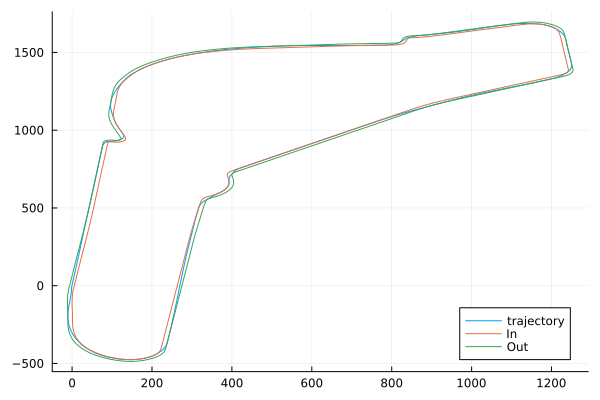

In [54]:
# get x and y from X
x = [X[i][1] for i = 1:N]
y = [X[i][2] for i = 1:N]
psi = [X[i][3] for i = 1:N]

# plot x vs y 
# increase the size of the plot
plot(x, y, label="trajectory")
plot!(xin, yin, label="In")
plot!(xout, yout, label="Out")



In [55]:
# calculate the mean error between x y and xopt yopt
error = 0
for i = 1:N
    error += sqrt((x[i] - xopt[i])^2 + (y[i] - yopt[i])^2)
end

error = error / N



0.1302916258665866

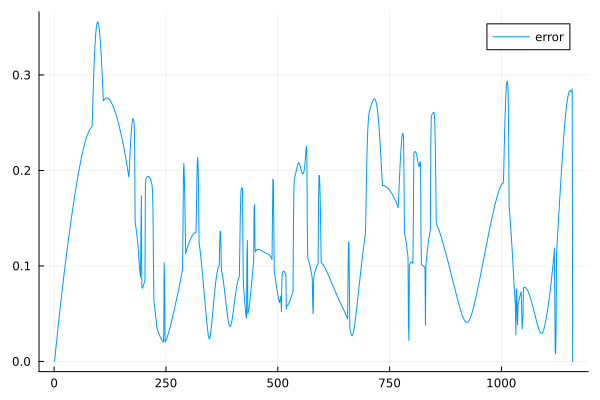

In [56]:
# calculate the error between x y and xopt yopt at each point
len = length(x)

error_vec = zeros(len)
for i = 1:len
    error_vec[i] = sqrt((x[i] - xopt[i])^2 + (y[i] - yopt[i])^2)
end
# plot the error
plot(error_vec, label="error")

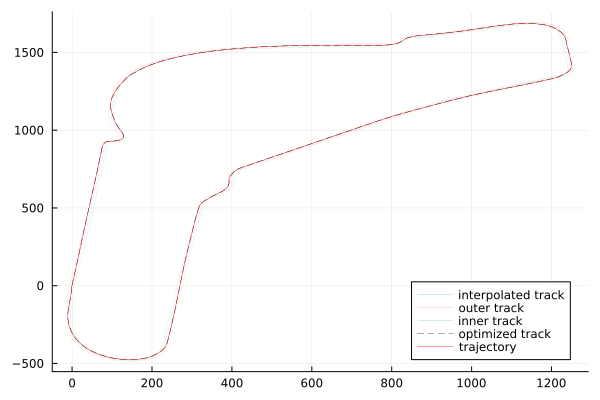

In [57]:
# plot x_i y_i
plot(x_i, y_i, label="interpolated track", legend=:bottomright, linewidth=0.1)
# plot xout yout
plot!(xout, yout, label="outer track", legend=:bottomright, linewidth=0.1)
# plot xin yin
plot!(xin, yin, label="inner track", legend=:bottomright, linewidth=0.1)
# plot xopt yopt
plot!(xopt, yopt, label="optimized track", legend=:bottomright, linewidth=0.4, linestyle=:dash, color=:black)
# plot x y
plot!(x, y, label="trajectory", legend=:bottomright, linewidth=0.4, color=:red)

In [58]:
#get velocity from U and plot it
# v = [U[i][1] for i = 1:(N-1)]
# plot(v, label="velocity")
U

1158-element Vector{Vector{Float64}}:
 [0.021223843675111043, 0.17355436790673648]
 [0.021316292029558155, 0.17233146795407253]
 [0.021406586179438383, 0.17111547020111753]
 [0.021494669772160295, 0.16990262309851464]
 [0.021580591488007388, 0.16869604140758682]
 [0.02166432260253746, 0.1674930366489692]
 [0.02174584603923558, 0.16629615616546936]
 [0.021825170480334614, 0.16510339980420596]
 [0.021902323162575378, 0.16391703884813444]
 [0.021977305284176143, 0.1627375608662495]
 ⋮
 [0.019120903921006616, -0.4987586503722948]
 [0.019606577380990416, -0.5018536025882162]
 [0.020087233992484858, -0.5046633766215299]
 [0.02053020565273266, -0.5072148452631593]
 [0.02086936676928814, -0.5095255554327636]
 [0.020964175699712356, -0.5116117371949097]
 [0.02041934534292808, -0.5134992012765758]
 [0.017242563952608418, -0.5152776885848239]
 [0.30598970662675073, -0.5235027882657478]